# Minimum Variance Portfolio, sample cov using MLE linear shrinkage

Shrinkage algorithm implemented from 
    Ledoit, O., and M. Wolf, 2003, “Honey, I Shrunk the Sample Covariance Matrix,” Working
    Paper, Department of Economics and Business, Universitat Pompeu Fabra.
Access: https://ssrn.com/abstract=433840

The performance of the shrinkage estimator is measured in MSE terms of the covariance matrix estimate, using the matrix Frobenius norm

$ ||\hat{\Sigma}-\Sigma||_F = \sqrt{\sum_{i,j} (\hat{\sigma}^2_{ij} - \sigma^2_{ij})^2 }$.
 That is, the squared residual of the element-wise covariances.
 
While the shrinkage estimator is a biased estimator, it can archive a lower MSE than the unbiased sample covariance by having a lower variance.

## Define benchmark returns statistics

['sample', 'honey', 'MP', 'SKL_LW', 'RIE']
[0.60327326 0.6372047  0.61130448 0.67063428 0.59532473]


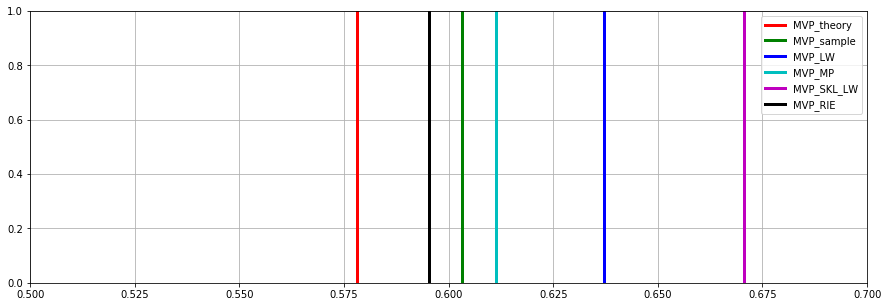

In [8]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import scipy.stats as stats
import pandas as pd
from operator import add
from matplotlib import pyplot as plt
import honey_shrink as hs
import marchenko_pastur as mp
from sklearn.covariance import LedoitWolf


from src.estimation.cov_cleaning import mp_denoise, RIE

import example_data as data



def mvh(idx_r, idx_h, pos, cov):
    idx_sub = np.concatenate([idx_r, idx_h])
    hrhh = cov[idx_h][:,idx_sub]
    hh = cov[idx_h][:, idx_h]
    hdg_h = -np.linalg.inv(hh) @ hrhh @ pos[idx_sub]
    hdg = np.concatenate((np.zeros(len(idx_r)), hdg_h))
    psi = np.zeros(cov.shape[0])
    psi[idx_sub] = hdg
    return psi

#def var(book, cov):
#    return book.pos @ cov.loc[book.pos.index, book.pos.index] @ book.pos

def var(w, cov):
    return w @ cov @ w
    
# =========================
# ======= Load Data =======
# =========================
lvl_df, book = data.get_example_data()
r = lvl_df.pct_change().iloc[1::]
#r = np.log(lvl_df.shift(1)) - np.log(lvl_df)
cov = r.cov() #ddof=N-1

#hedges = ['SX5E', 'OMX']
hedges = ['SWEDA SS', 'AMEAS FH', 'CAST SS']
subverse = set(book.pos.index.values).union(set(hedges))
subcov = cov.loc[subverse, subverse]
idx_r = np.array([subcov.index.get_loc(x) for x in book.pos.index])
idx_h = np.array([subcov.index.get_loc(x) for x in hedges])
pos = np.zeros(subcov.shape[0])
pos[idx_r] = book.pos.values
hdg = mvh(idx_r, idx_h, pos, subcov.values)
var0 = var(pos, subcov)
var1 = var(pos+hdg, subcov)
rat0 = np.sqrt(var1/var0)

dist = stats.multivariate_normal(cov=subcov)
nsim = 1000
nsamples = 40
data = np.empty((nsim, 5))
labels = ['sample', 'honey', 'MP', 'SKL_LW', 'RIE']
for i in range(nsim):
    X = dist.rvs(nsamples)
    sample_cov = np.cov(X, rowvar=False, ddof=1)
    
    hdg_pos = mvh(idx_r, idx_h, pos, sample_cov)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,0] = np.sqrt(var1/var0)
    
    cov_est1 = hs.honey_shrink(X)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est1)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,1] = np.sqrt(var1/var0)
    
    cov_est2 = mp_denoise(sample_cov, sample_cov.shape[0], nsamples)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est2)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,2] = np.sqrt(var1/var0)
    
    
    cov_est3 =  LedoitWolf().fit(sample_cov).covariance_
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est3)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,3] = np.sqrt(var1/var0)
    
    cov_est4 =  RIE(sample_cov, sample_cov.shape[0], nsamples, corrmode=False)
    hdg_pos = mvh(idx_r, idx_h, pos, cov_est4)
    var1 = (pos+hdg_pos) @ subcov @ (pos+hdg_pos)
    data[i,4] = np.sqrt(var1/var0)        
    
    
est = np.mean(data, axis=0)
print(labels)
print(est)
#rank = np.argmin(est)
plt.figure(figsize=(15,5))
#plt.hist(data[:,0], density=True, bins='auto', color='g', alpha=0.2)
#plt.hist(data[:,1], density=True, bins='auto', color='b', alpha=0.2)
plt.axvline(rat0, color='r', linewidth=3, label='MVP_theory')
plt.axvline(est[0], color='g', linewidth=3, label='MVP_sample')
plt.axvline(est[1], color='b', linewidth=3, label='MVP_LW')
plt.axvline(est[2], color='c', linewidth=3, label='MVP_MP')
plt.axvline(est[3], color='m', linewidth=3, label='MVP_SKL_LW')
plt.axvline(est[4], color='k', linewidth=3, label='MVP_RIE')
lim = (int(rat0*10)/10, int(1+max(est)*10)/10)
plt.xlim([lim[0], lim[1]])
#plt.xticks(np.arange(lim[0], lim[1], 0.05))
plt.legend(loc='best')
plt.grid(True)
plt.show()



## Calculate measures based on benchmark return distribution